## *Initial attempts to extract signals from the noisy ocean dynamics dataset involved testing models such as Convolutional Neural Networks (CNNs) and Denoising Autoencoders (DAEs). After further analysis of data distributions and statistical properties, these models were discarded due to their limitations in effectively capturing the underlying patterns.*

In [ ]:
!pip install netCDF4
!pip install xarray
!pip install xbatcher
!pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import IterableDataset
import numpy as np
from tqdm import tqdm
from netCDF4 import Dataset as NetCDFFile
import xarray as xr
import matplotlib.pyplot as plt
# import gc
import xbatcher
# import Geohash
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive")

In [ ]:
# just fingerprints (output from David's code)
fingerprint_file = r'projects/EPS 91/SSH_Patterns.nc'

# full ocean dynamics (output from Sonke's code)
ocean_dynamics_file = r'projects/EPS 91/GLORYS_Surrogate_Combined_40320sims.nc'

synthetics_file = r'projects/EPS 91/synthetics.pkl'

In [ ]:
# synthetic fingerprints dataset
immutable_fingerprints = xr.open_dataset(fingerprint_file)
fingerprints = immutable_fingerprints.copy(deep=True)

#### Visualize Synthetic Fingerprints

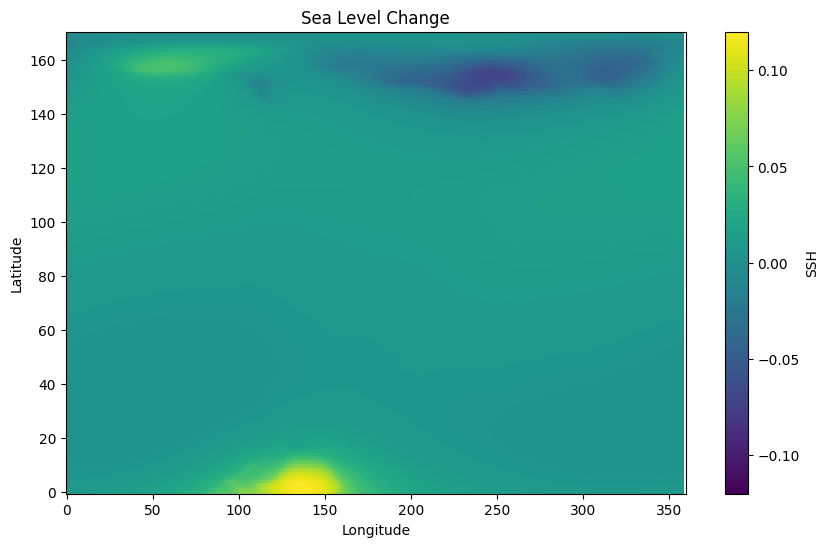

In [ ]:
# Select timestep/simualtion number
fingerprint_data_slice = fingerprints['SSH'].isel(time=1, nsim=1)

plt.figure(figsize=(10, 6))
fingerprint_data_slice.plot(cmap='viridis')
plt.title('Sea Level Change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# synthetic ocean dynamics dataset
immutable_ocean_dynamics = xr.open_dataset(ocean_dynamics_file)
ocean_dynamics = immutable_ocean_dynamics.copy(deep=True)

#### Visualize Synthetic Ocean Dynamics Field

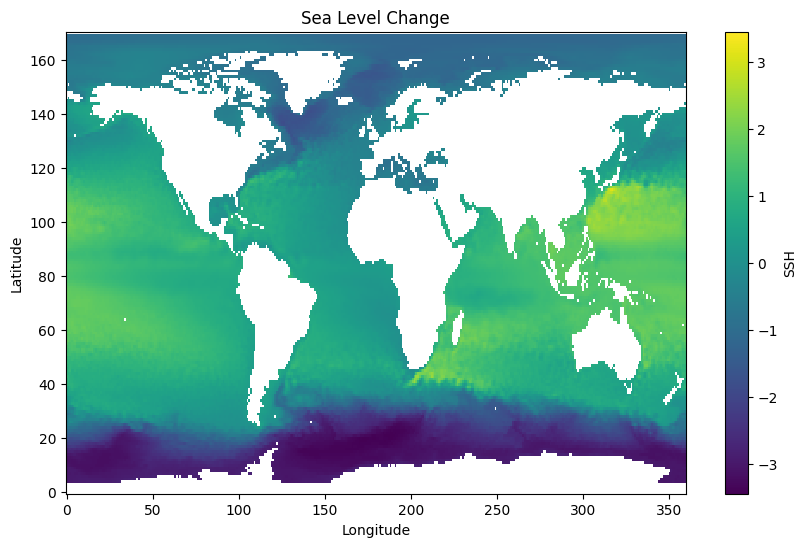

In [ ]:
# Select timestep/simualtion number
surrogate_data_slice = ocean_dynamics['SSH'].isel(time=0, nsim=0)

plt.figure(figsize=(10, 6))
surrogate_data_slice.plot(cmap='viridis')
plt.title('Sea Level Change')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
print(ocean_dynamics['time'])
print('-'*80)
print(fingerprints['time'])

<xarray.DataArray 'time' (time: 336)> Size: 1kB
array([1993.    , 1993.0834, 1993.1666, ..., 2020.75  , 2020.8334, 2020.9166],
      dtype=float32)
Coordinates:
  * time     (time) float32 1kB 1.993e+03 1.993e+03 ... 2.021e+03 2.021e+03
--------------------------------------------------------------------------------
<xarray.DataArray 'time' (time: 336)> Size: 1kB
array([9.96921e+36, 9.96921e+36, 9.96921e+36, ..., 9.96921e+36, 9.96921e+36,
       9.96921e+36], dtype=float32)
Coordinates:
  * time     (time) float32 1kB 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36


In [ ]:
with open(synthetics_file, 'rb') as file:
    synthetics = pickle.load(file)

In [ ]:
# Define the dimensions for the dataset
synthetics_ds = xr.Dataset(
    {
        'SSH': (['time', 'lat', 'lon', 'nsim'], synthetics['SSH'].values)
    }
)

# Check the dataset structure
print(synthetics_ds)

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 336, lat: 171, lon: 360, nsim: 120)
Dimensions without coordinates: time, lat, lon, nsim
Data variables:
    SSH      (time, lat, lon, nsim) float32 10GB nan nan nan nan ... nan nan nan


#### Visualize Full Synthetic Field

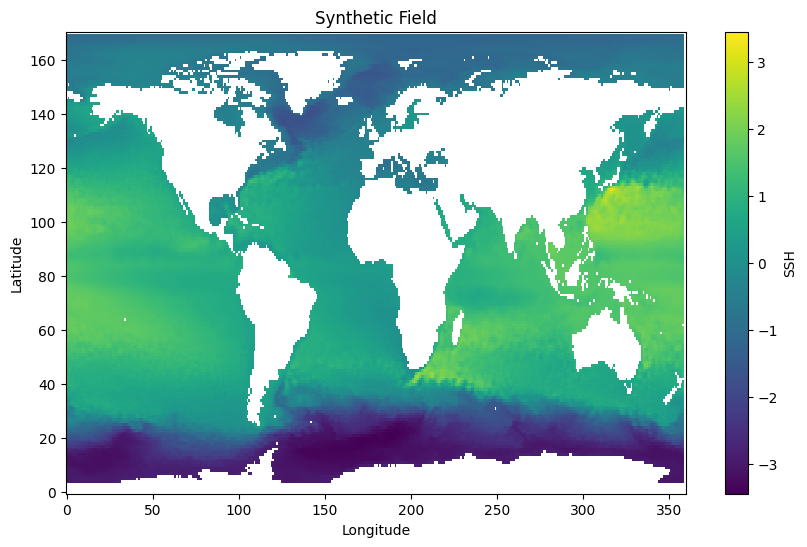

In [ ]:
combined_ssh_slice = synthetics_ds['SSH'].isel(time=0, nsim=0)
plt.figure(figsize=(10, 6))
combined_ssh_slice.plot(cmap='viridis')
plt.title('Synthetic Field')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Generate batches of data for training. Input_gen full ocean dynamics combined with fingerprints and target_gen contains only fingerprint (our model's prediction targets)

In [ ]:
import xarray as xr

# Define the starting indices for latitude and longitude for your patch
lat_start = 30
lon_start = 175

lat_max = 171
lon_max = 360

offset = 120
num_clean = 10000

# Select the 5x5-degree patch from both datasets (synthetics and fingerprints)
# input_patch = synthetics_ds.isel(lat=slice(lat_start, lat_start + offset), lon=slice(lon_start, lon_start + offset))
# target_patch = fingerprints.isel(lat=slice(lat_start, lat_start + offset), lon=slice(lon_start, lon_start + offset))
# noise_patch = ocean_dynamics.isel(lat=slice(lat_start, lat_start + offset), lon=slice(lon_start, lon_start + offset))

# Collapse 'time' and 'nsim' into a single 'sim' dimension for input and target patches
# input_collapsed = synthetics_ds.stack(sim=('time', 'nsim'))
# signal_collapsed = fingerprints.stack(sim=('time', 'nsim'))
noise_collapsed = ocean_dynamics.stack(sim=('time', 'nsim'))

# # Extract clean and noisy segments
# clean = target_patch_collapsed.isel(sim=slice(0, num_clean)).copy(deep=True)
# noisy = input_patch_collapsed.isel(sim=slice(num_clean, input_patch_collapsed.sizes['sim'])).copy(deep=True)

# # Convert to NumPy arrays
# clean_array = np.array(clean['SSH'].values)
# noisy_array = np.array(noisy['SSH'].values)

# # Concatenate the NumPy arrays
# combined_input_array = np.concatenate((noisy_array, clean_array), axis=2)

# # Convert back to xarray dataset
# combined_input = xr.DataArray(combined_input_array, dims=('lat', 'lon', 'sim'), coords={'lat': input_patch_collapsed['lat'], 'lon': input_patch_collapsed['lon'], 'sim': np.arange(combined_input_array.shape[-1])})
# combined_target = target_patch_collapsed.copy(deep=True)
# # Check the new dimensions
# print(combined_input.dims)
# print(combined_target.dims)


#### Train/Validation splits and Batch Generators

In [ ]:
# # Shuffle the combined dataset uniformly
# indices = np.random.permutation(signal_collapsed.sizes['sim'])
# # shuffled_input = input_collapsed.isel(sim=indices)
# shuffled_signal = signal_collapsed.isel(sim=indices)
# shuffled_noise = noise_collapsed.isel(sim=indices)

# # Define the split index for train/validation based on the shuffled data
split_idx = int(0.8 * noise_collapsed.sizes['sim'])

# Training set (80% of the 'sim' dimension)
# input_train = shuffled_input.isel(sim=slice(0, split_idx))
# signal_train = signal_collapsed.isel(sim=slice(0, split_idx))
noise_train = noise_collapsed.isel(sim=slice(0, split_idx))


# Validation set (remaining 20% of the 'sim' dimension)
# input_val = shuffled_input.isel(sim=slice(split_idx, None))
# signal_val = signal_collapsed.isel(sim=slice(split_idx, None))
noise_val = noise_collapsed.isel(sim=slice(split_idx, None))

# BatchGenerators for the training set (shuffled data)
# train_input_gen = xbatcher.BatchGenerator(input_train, {'sim': split_idx, 'lat': offset, 'lon': offset})
# train_signal_gen = xbatcher.BatchGenerator(signal_train, {'sim': split_idx, 'lat': lat_max, 'lon': lon_max})
# train_noise_gen = xbatcher.BatchGenerator(noise_train, {'sim': split_idx, 'lat': offset, 'lon': offset})


# BatchGenerators for the validation set (shuffled data)
# val_input_gen = xbatcher.BatchGenerator(input_val, {'sim': input_val.sizes['sim'], 'lat': offset, 'lon': offset})
# val_signal_gen = xbatcher.BatchGenerator(signal_val, {'sim': signal_val.sizes['sim'], 'lat': offset, 'lon': offset})
# val_noise_gen = xbatcher.BatchGenerator(noise_val, {'sim': noise_val.sizes['sim'], 'lat': offset, 'lon': offset})

In [ ]:
del immutable_fingerprints, fingerprints, immutable_ocean_dynamics, ocean_dynamics, synthetics, synthetics_ds, noise_val, noise_collapsed

In [ ]:
# Function to visualize input, prediction, and target for multiple samples
def visualize_examples(inputs, predictions, targets, offset, num_examples=5):

    for i in range(num_examples):
        input_sample = inputs[i].squeeze().numpy()  # (5, 5)
        prediction_sample = predictions[i].detach().numpy().reshape(offset, offset)  # Reshape to (offset, offset)
        target_sample = targets[i].detach().numpy().reshape(offset, offset)  # Reshape to (offset, offset)

        # Plot input, prediction, and target side by side
        fig, axes = plt.subplots(1, 3, figsize=(offset*5, offset))

        # Input visualization
        axes[0].imshow(input_sample, cmap='viridis', interpolation='none')
        axes[0].set_title(f"Input {i + 1}")
        axes[0].axis('off')

        # Prediction visualization
        axes[1].imshow(prediction_sample, cmap='viridis', interpolation='none')
        axes[1].set_title(f"Prediction {i + 1}")
        axes[1].axis('off')

        # Target visualization
        axes[2].imshow(target_sample, cmap='viridis', interpolation='none')
        axes[2].set_title(f"Target {i + 1}")
        axes[2].axis('off')

        plt.show()

In [ ]:
def z_score_normalize(a):
  func = lambda x: (x - np.mean(x)) / np.std(x)
  return xr.apply_ufunc(func, a)

In [ ]:
def max_normalize(a):
  func = lambda x: x/np.max(x)
  return xr.apply_ufunc(func, a)

In [ ]:
def percentile(a):
  func = lambda x: np.percentile(x, [5, 10, 50, 90, 95])
  return xr.apply_ufunc(func, a)

In [ ]:

def patch_norm(input, patch_dim=5):
# Input is size 30,000 x 171 x 360. Convert to smaller patch size
  sim_dim = input.sizes['sim']
  lat_dim = input.sizes['lat']
  lon_dim = input.sizes['lon']

  input_gen = xbatcher.BatchGenerator(input, {'sim': sim_dim, 'lat': patch_dim, 'lon': patch_dim})
  tmp = []
  for batch in input_gen:

    batch = np.transpose(batch['SSH'].values, (2, 0, 1)) # size 30,000 x patch_dim, patch_dim

    patch_norm = np.divide(batch, np.max(batch, axis=(1, 2), keepdims=True))

    tmp.append(patch_norm)

  norm_array = np.concatenate(tmp, axis=0)

  norm_array = xr.DataArray(norm_array, dims=('lat', 'lon', 'sim'), coords={'lat': lat_dim, 'lon': lon_dim, 'sim': sim_dim})

  return norm_array


In [ ]:

def nan_filter(input, threshold=0.2, patch_dim=5):
# Input is size 30,000 x 171 x 360. Convert to smaller patch size
  sim_dim = input.sizes['sim']
  lat_dim = input.sizes['lat']
  lon_dim = input.sizes['lon']
  input_gen = xbatcher.BatchGenerator(input, {'sim': sim_dim, 'lat': patch_dim, 'lon': patch_dim})
  tmp = []
  for batch in input_gen:

    batch = np.transpose(batch['SSH'].values, (2, 0, 1)) # size 30,000 x patch_dim, patch_dim

    input_filtered = np.nan_to_num(batch, nan=0)

    zero_count = np.count_nonzero(input_filtered == 0, axis=(1, 2))

    total_pixels = input_filtered.shape[1] * input_filtered.shape[2]

    zero_ratio = zero_count / total_pixels

    mask = zero_ratio <= threshold

    filtered_patches = input_filtered[mask]

    tmp.append(filtered_patches)

  filtered_array = np.concatenate(tmp, axis=0)

  filtered_array = xr.DataArray(filtered_array, dims=('lat', 'lon', 'sim'), coords={'lat': lat_dim, 'lon': lon_dim, 'sim': sim_dim})
  filtered_array = filtered_array.astype(np.float16)

  return filtered_array


Distribution seems to change depending on how we aggregate data. When input is of size num_simx x height x width, distribution of pixel values changes depending on position. Need to normalize with respect to local maxes (within
patch), positional maxes (across all simulations, within patch), and global maxes (self-explanatory).

In [ ]:
def layer_shape(x, kernel, stride, padding):
  return (x.shape[-1] - kernel + 2*padding)/stride + 1

In [ ]:
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    # print(self.layer_shape(x/, 3, 1, 0)
    # print('Shape after Conv1: ', x.shape)
    x = self.pool(self.relu(self.conv2(x)))
    # print('Shape after Conv2: ', x.shape)
    x = self.pool(self.relu(self.conv3(x)))


    return x

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.transconv1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0)

    self.transconv2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0)
    self.relu = nn.ReLU()


  def forward(self, x):
    x = self.transconv1(self.relu(x))
    # print('Shape after TransConv1: ', x.shape)

    x = self.transconv2(self.relu(x))
    # print('Shape after TransConv2: ', x.shape)
    return x

class CDAE(nn.Module):
  def __init__(self):
    super(CDAE, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()
    self.final = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    input_shape = x.shape
    x = self.decoder(self.encoder(x))
    x = self.final(x)
    assert x.shape == input_shape  # Keep the output in spatial format

    return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.image import TotalVariation
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

# Define the normalization function
def z_score_normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the enhanced model, move to device
mcnn = CDAE().to(device)
criterion = nn.MSELoss().to(device)
tv = TotalVariation().to(device)
tv_weight = 1e-2
moptimizer = optim.Adam(mcnn.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(moptimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

# Lists to track loss
train_losses = []
val_losses = []

# Training loop
epochs = 300
for epoch in range(epochs):
    mcnn.train()
    train_running_loss = 0.0

    for train_input_batch, train_target_batch in zip(train_input_gen, train_target_gen):
        # Convert inputs and targets to tensors and move to the device
        train_input = torch.tensor(train_input_batch.values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1).to(device)
        train_target = torch.tensor(train_target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1).to(device)

        train_input = z_score_normalize(train_input)

        # Zero the gradients
        mcnn.zero_grad()

        # Mixed precision forward pass
        with torch.autocast(device_type="cuda"):
            predictions = mcnn(train_input)

            # Compute losses
            zero_penalty = torch.sum((predictions == 0).float())  # Count how many predictions are 0
            tv_loss = tv(predictions)
            train_magnitude_mse_loss = criterion(predictions.to(device), train_target)
            train_loss = 1e4 * train_magnitude_mse_loss + zero_penalty + tv_weight * tv_loss

        # Mixed precision backward pass and optimization
        scaler.scale(train_loss).backward()
        nn.utils.clip_grad_norm_(mcnn.parameters(), max_norm=5.0)
        scaler.step(moptimizer)
        scaler.update()

        # Track running loss
        train_running_loss += train_loss.item()

    # Validation loop
    mcnn.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        for val_input_batch, val_target_batch in zip(val_input_gen, val_target_gen):
            # Convert inputs and targets to tensors and move to the device
            val_input = torch.tensor(val_input_batch.values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1).to(device)
            val_target = torch.tensor(val_target_batch['SSH'].values, dtype=torch.float32).permute(2, 0, 1).unsqueeze(1).to(device)

            val_input = z_score_normalize(val_input)

            # Mixed precision forward pass
            with torch.autocast(device_type="cuda"):
                val_predictions = mcnn(val_input)

                zero_penalty = torch.sum((val_predictions == 0).float())  # Count how many predictions are 0
                val_magnitude_mse_loss = criterion(val_predictions, val_target)
                val_loss = val_magnitude_mse_loss

            # Track running loss
            val_running_loss += val_loss.item()

    # Record average losses for epoch
    train_losses.append(train_running_loss / len(train_input_gen))
    val_losses.append(val_running_loss / len(val_input_gen))

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    # Adjust learning rate based on validation loss
    scheduler.step(val_running_loss)

    # Clear GPU cache to prevent memory leaks
    torch.cuda.empty_cache()

# Plotting losses
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Training Loss', color='g')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(train_input.cpu(), predictions.cpu(), train_target.cpu(), offset=offset)

In [ ]:
# Visualize 5 examples after the final epoch
with torch.no_grad():
    visualize_examples(val_input.cpu(), val_predictions.cpu(), val_target.cpu(), offset=offset)